In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


# Check if running in an interactive environment and set the file path accordingly
if '__file__' in globals():
    script_dir = os.path.dirname(__file__)
else:
    script_dir = os.getcwd()

# Add the path with llm_agents to the sys path
sys.path.append(os.path.join(script_dir, 'llm_agents'))

from process_score_calculator import prepare_calculations as calculate_scores
from performance_analyzer import perform_analysis as analyze_performance
from openai_image_analyzer import analyze_image
from openai_agents_analysts import main as analyze_agents

import warnings
warnings.filterwarnings("ignore")

In [2]:

scores_data = calculate_scores(MAC=True, DataName="BPIC_2019", layer="General_Process_Standards", index='case_id', view='Process_Cost')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data = scores_data.data
data.head(2)

,eventID,cat_dim_5,cat_dim_4,cat_dim_3,cat_dim_2,case_Purchasing_Document,case_Purch._Doc._Category_name,cat_dim_8,cat_dim_6,cat_dim_7,cat_dim_9,cat_dim_10,case_Name,case_GR-Based_Inv._Verif.,case_Item,case_id,cat_dim_12,cat_dim_resource,event_org_resource,activity,num_dim_1,timestamp,@@index,@@case_index,case:concept:name,concept:name,time:timestamp,score_found_case_id,score_sequential_case_id,score_equilibrium_case_id,score_singular_case_id,score_exclusion_case_id,mean_score
0,536870912000,Marketing,companyID_0000,EC Purchase order,Digital Marketing,2000000100,Purchase order,vendorID_0053,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0053,True,1,2000000100_00001,True,NONE,NONE,Vendor creates invoice,7815013.0,2017-01-31 23:59:00+00:00,0,0,2000000100_00001,Vendor creates invoice,2017-01-31 23:59:00+00:00,0.0,0.000921,0.0,0.0,0.0,0.000184
1,536870912001,Marketing,companyID_0000,EC Purchase order,Digital Marketing,2000000100,Purchase order,vendorID_0053,Service,"3-way match, invoice after GR",NPR,sourceSystemID_0000,vendor_0053,True,1,2000000100_00001,True,NONE,NONE,Vendor creates invoice,7815013.0,2017-05-25 23:59:00+00:00,1,0,2000000100_00001,Vendor creates invoice,2017-05-25 23:59:00+00:00,0.0,0.000921,0.0,0.0,0.0,0.000184


## Analyze individual performance

Analyze performance for logistic  and enterprise services category:

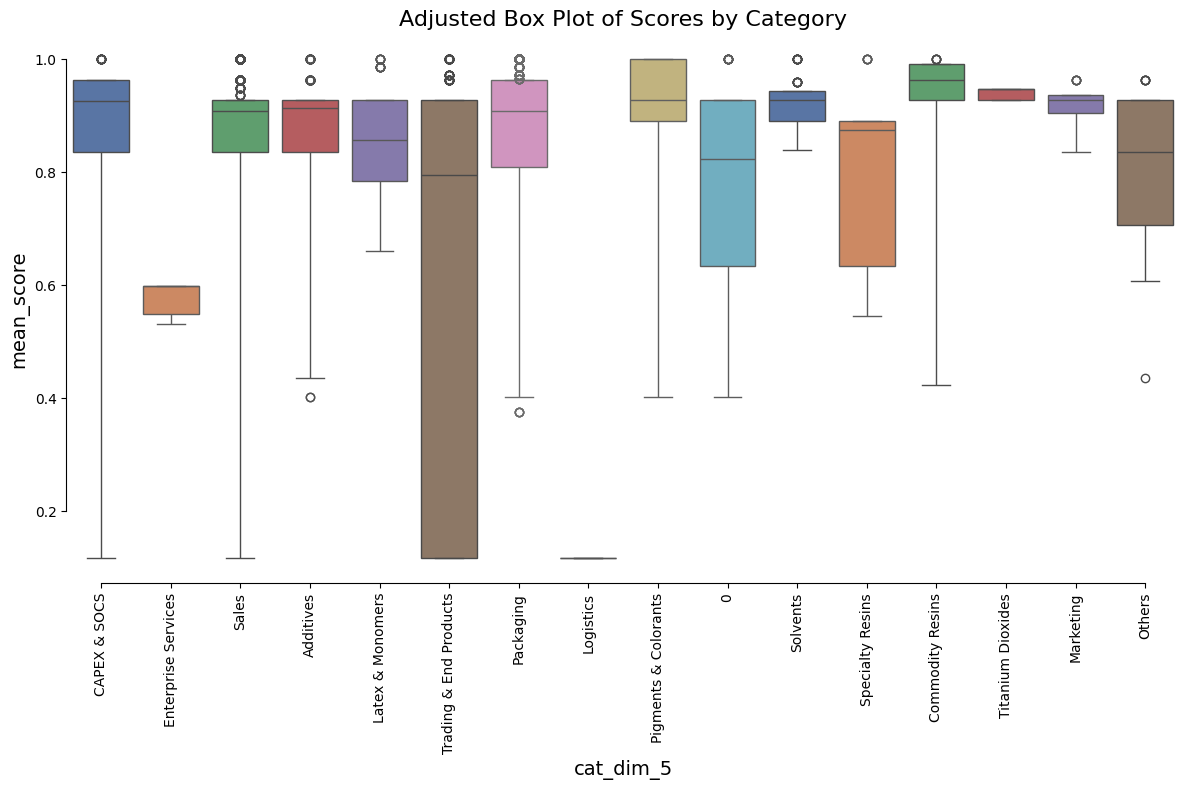

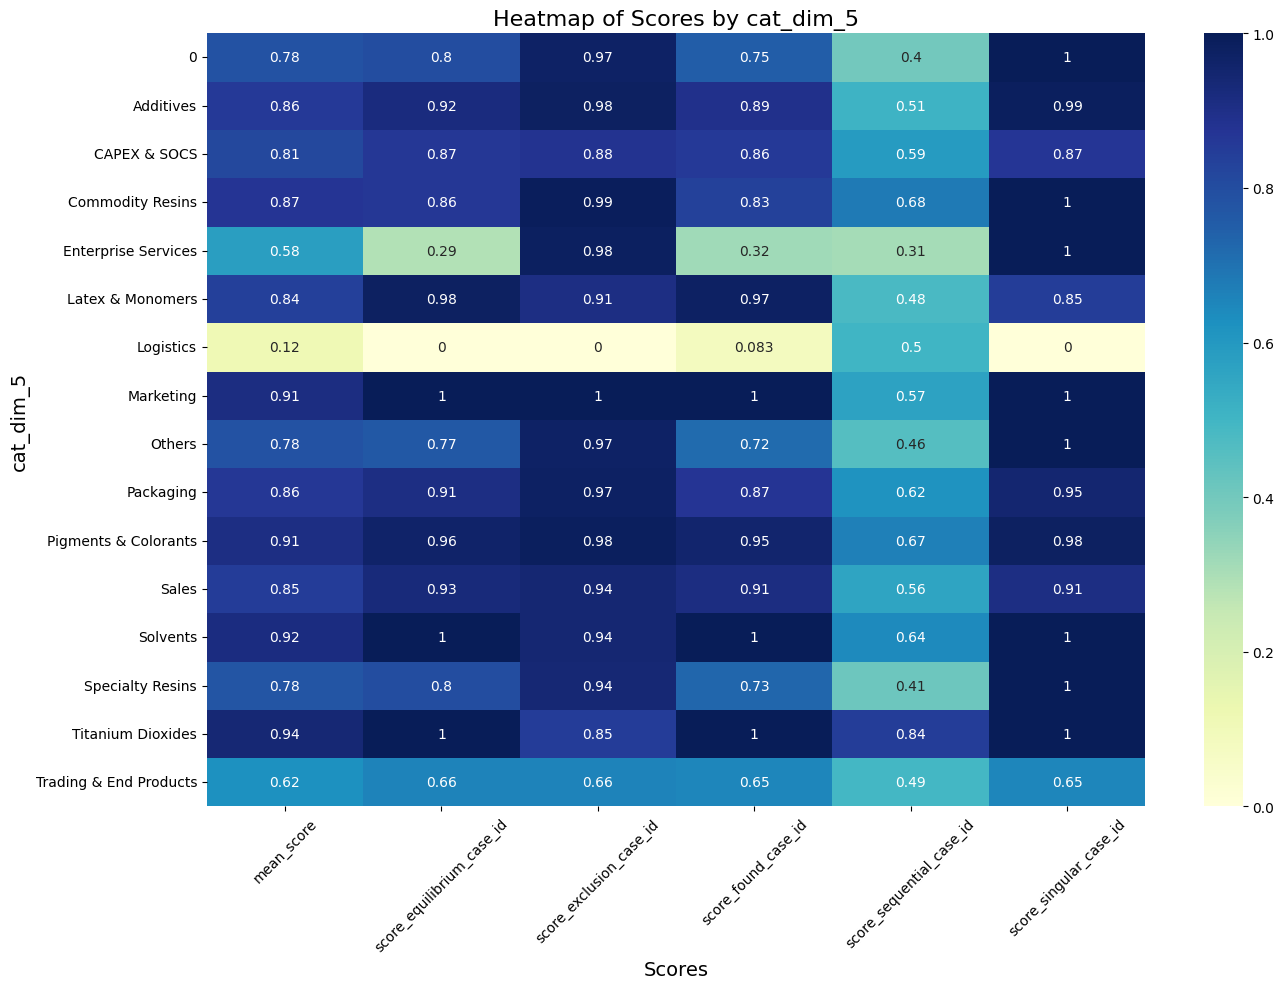

In [3]:
data_inv_gr = data[data['cat_dim_7'] == '3-way match, invoice before GR']
analyze_performance(visualize=True, category='cat_dim_5', score='mean_score', data_filtered=data_inv_gr)

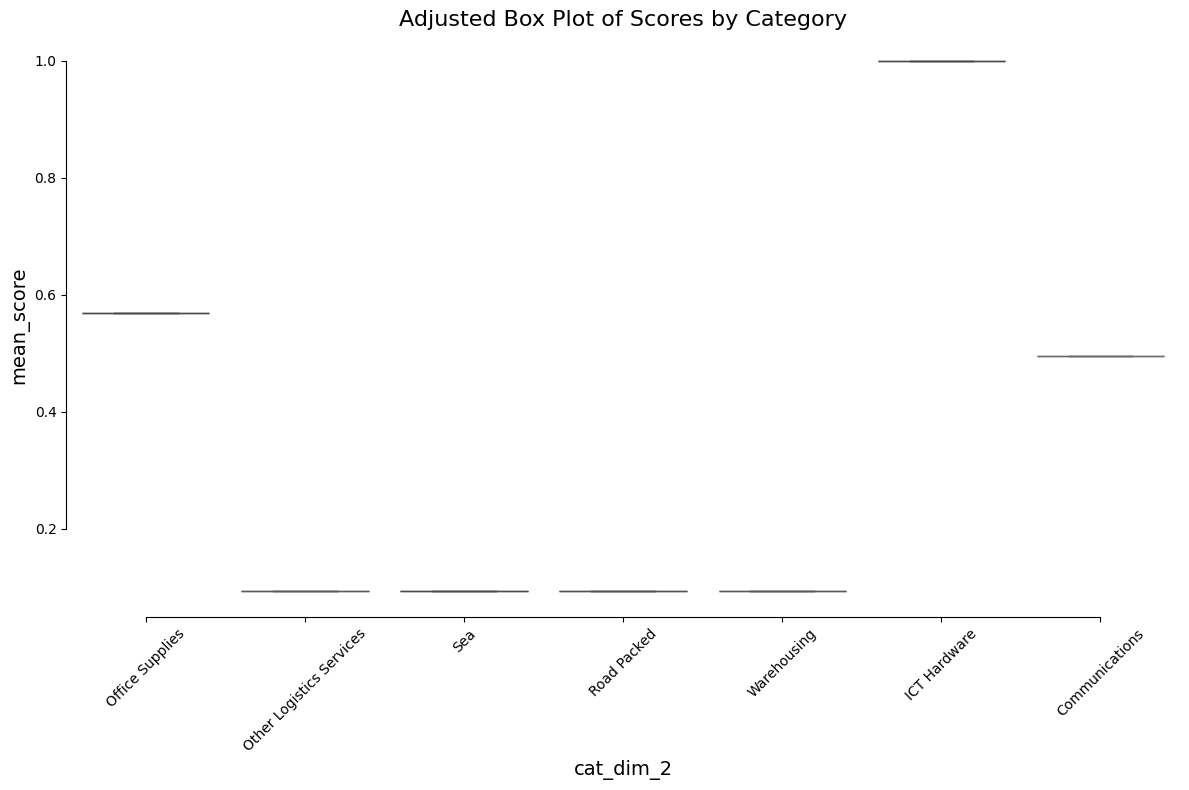

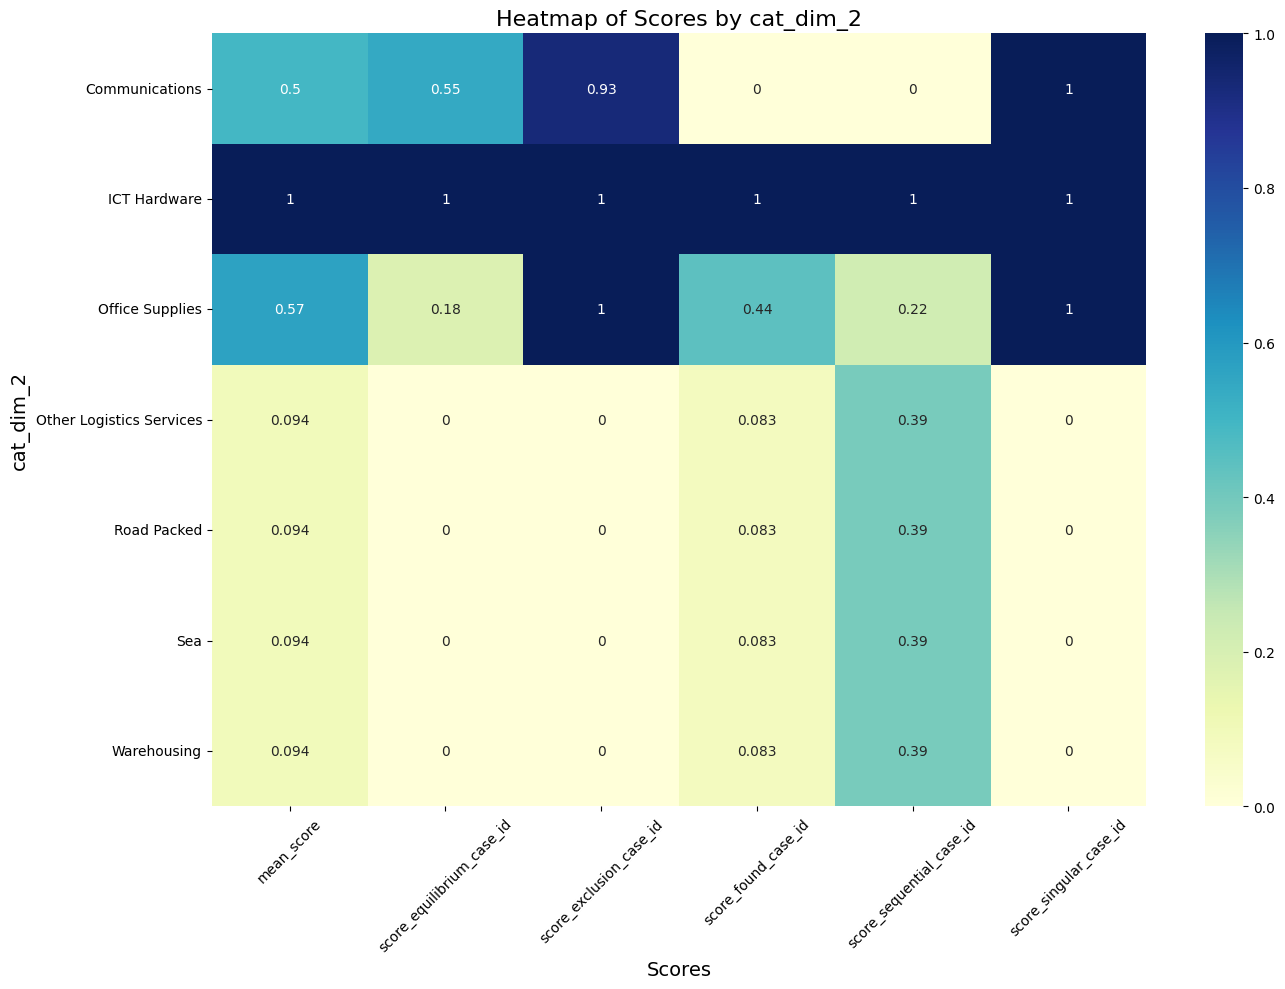

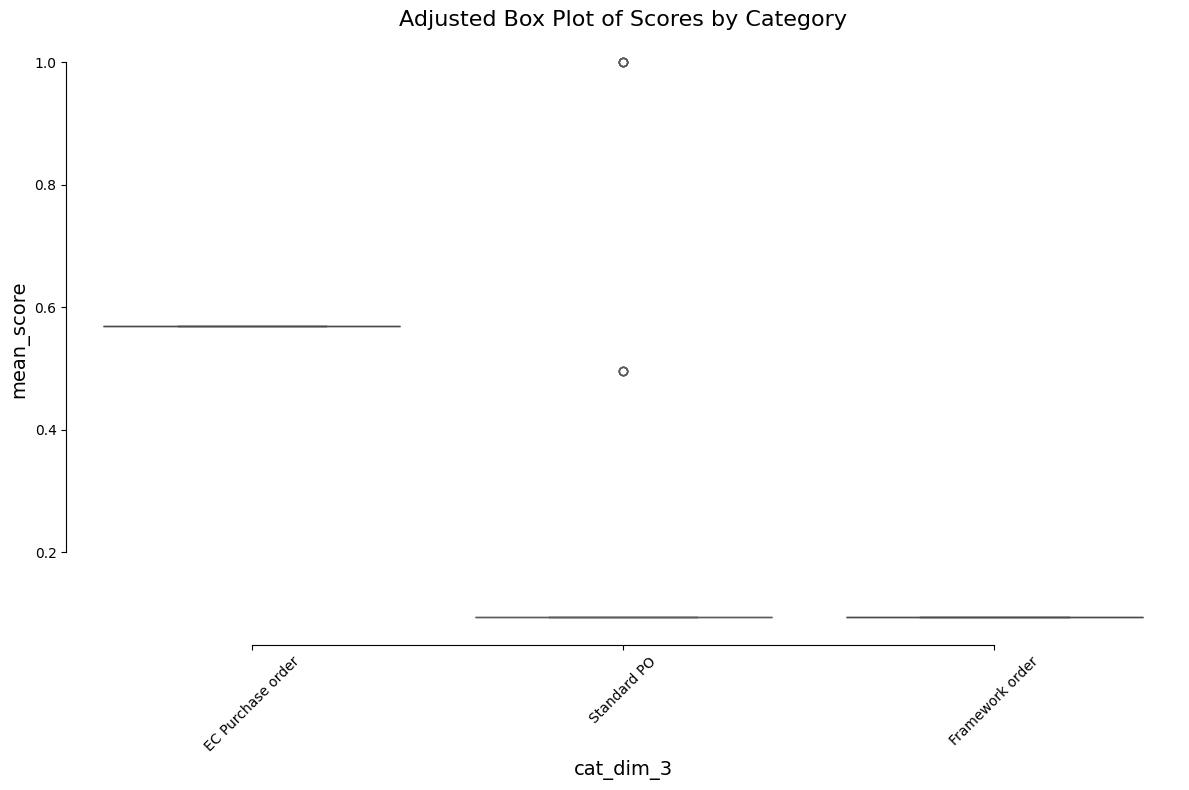

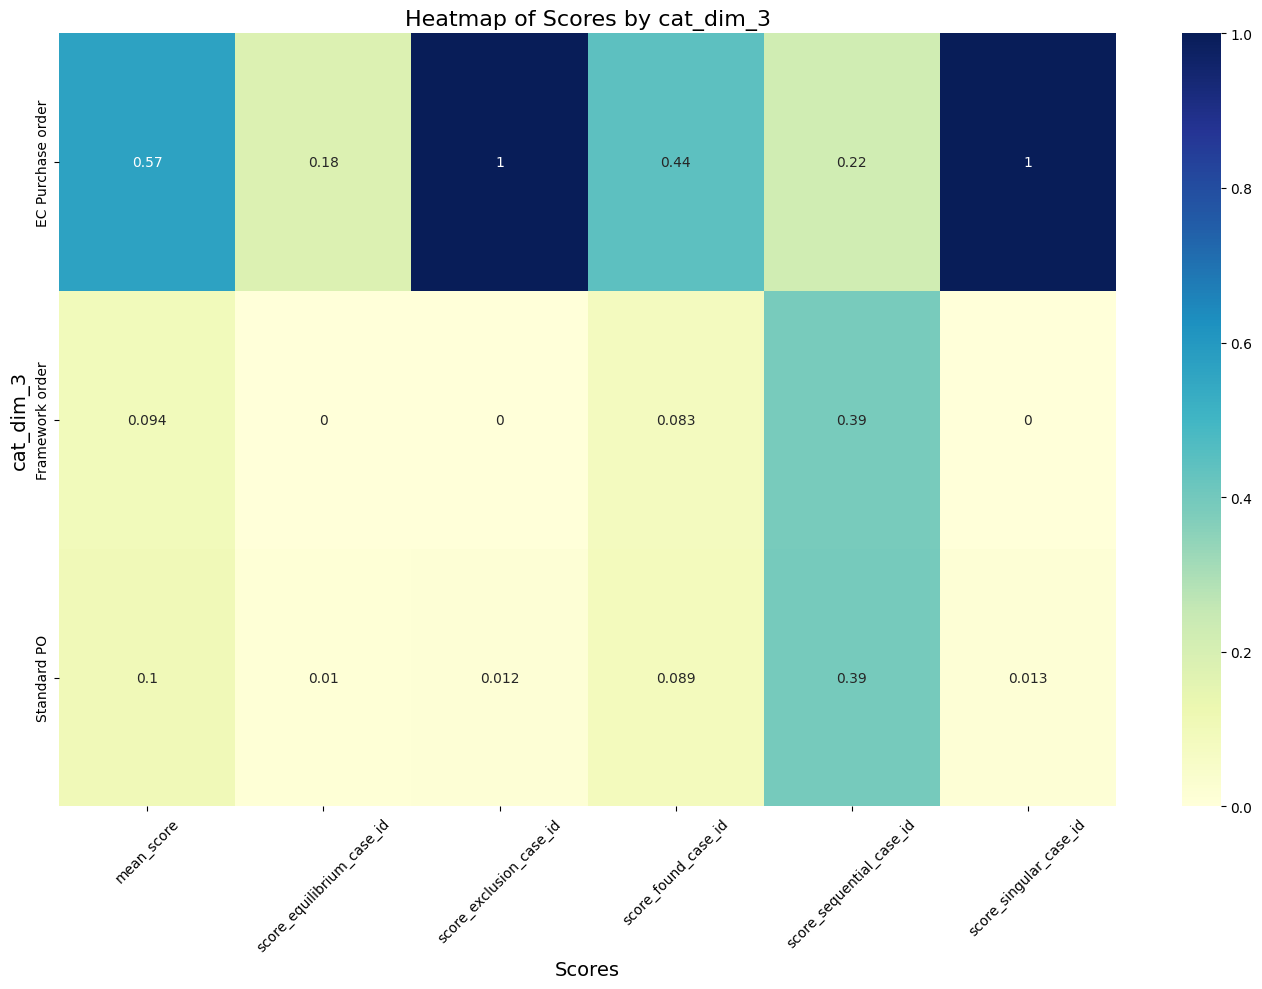

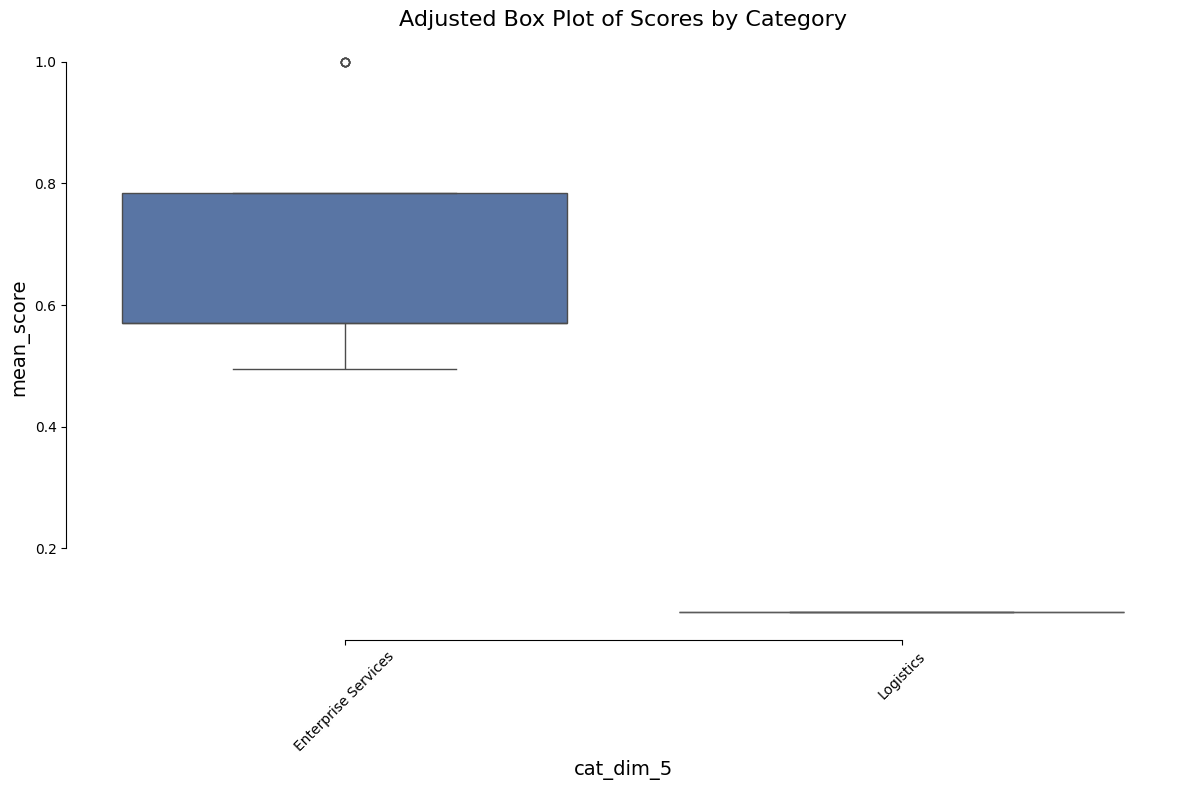

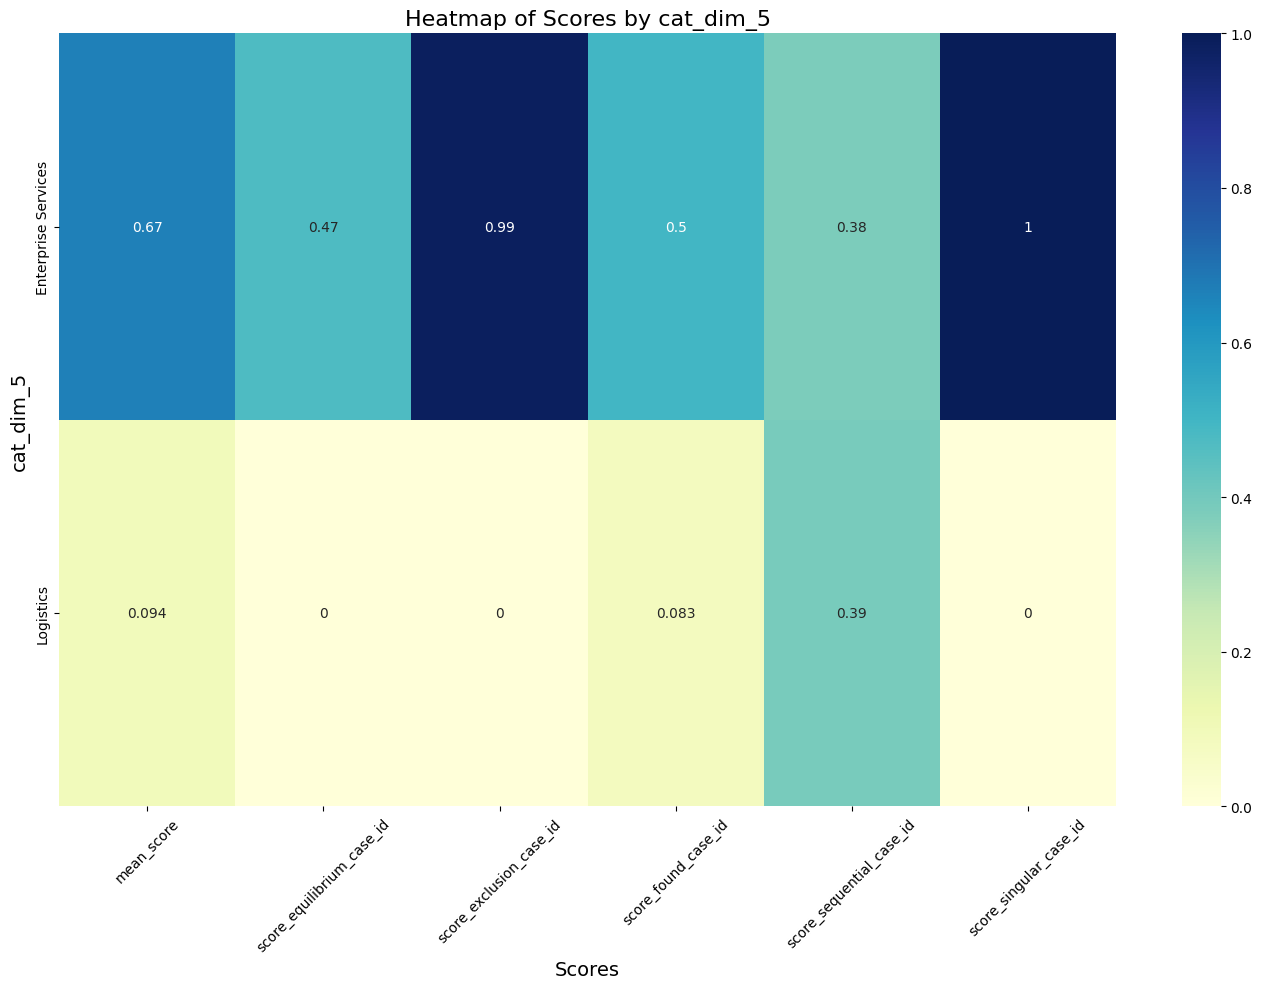

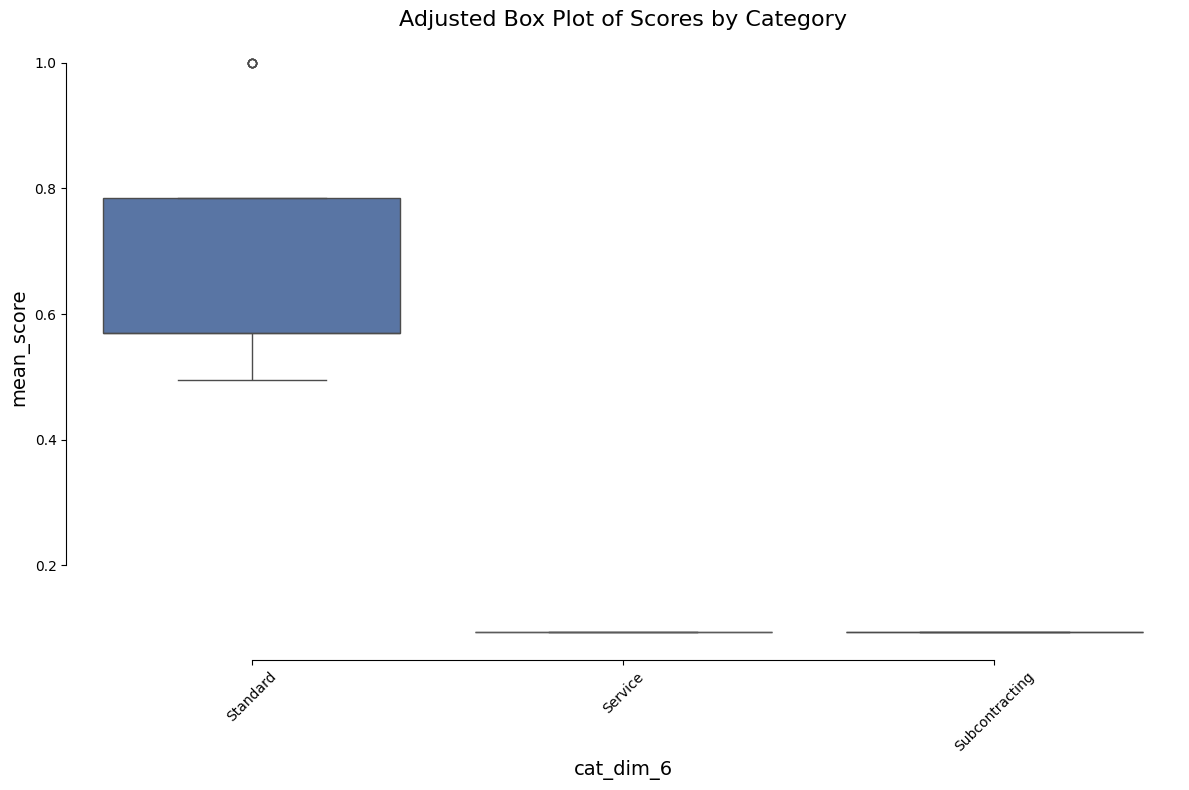

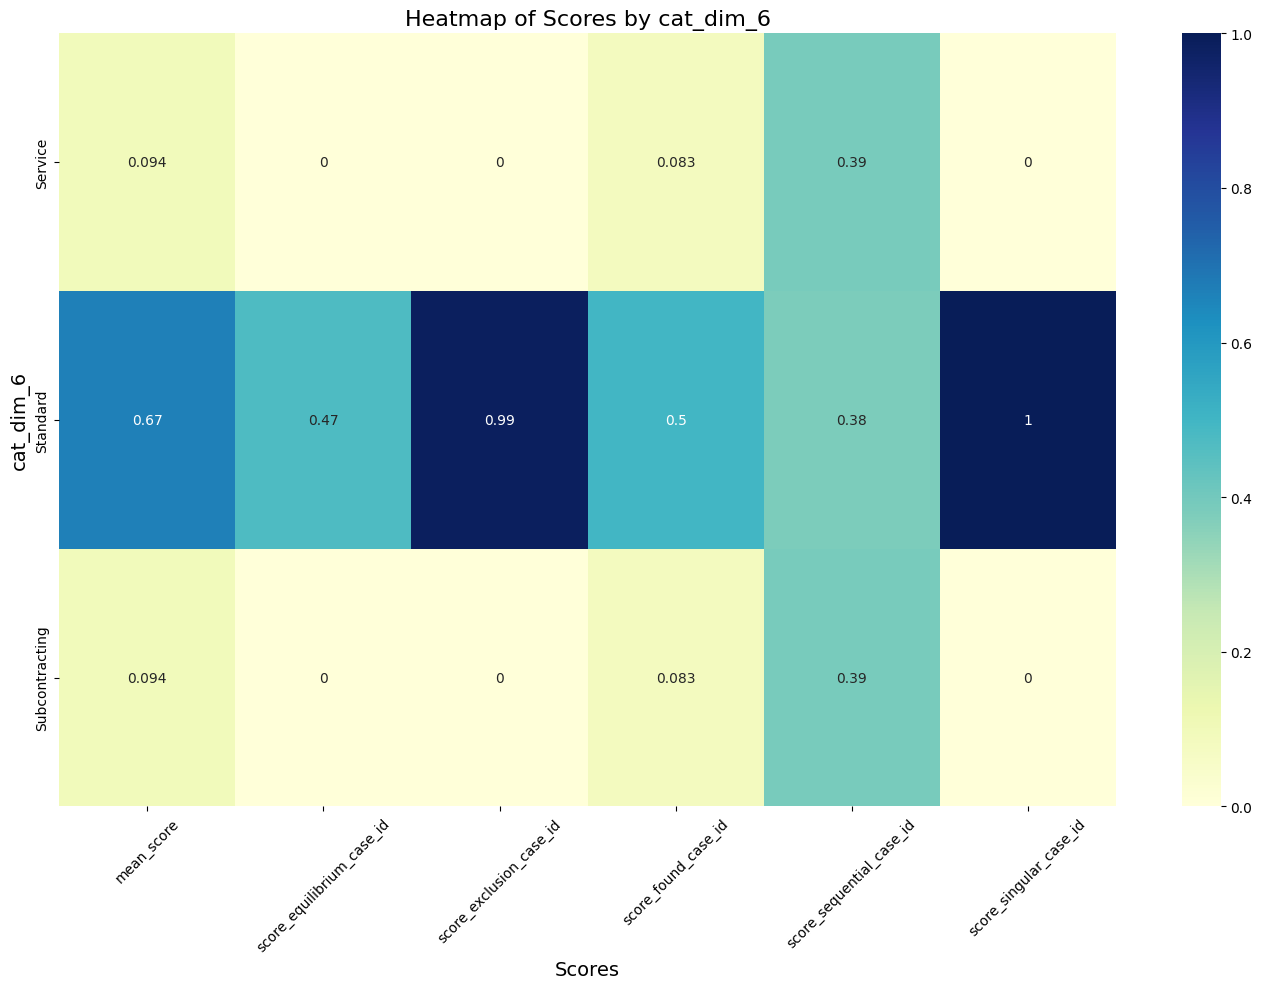

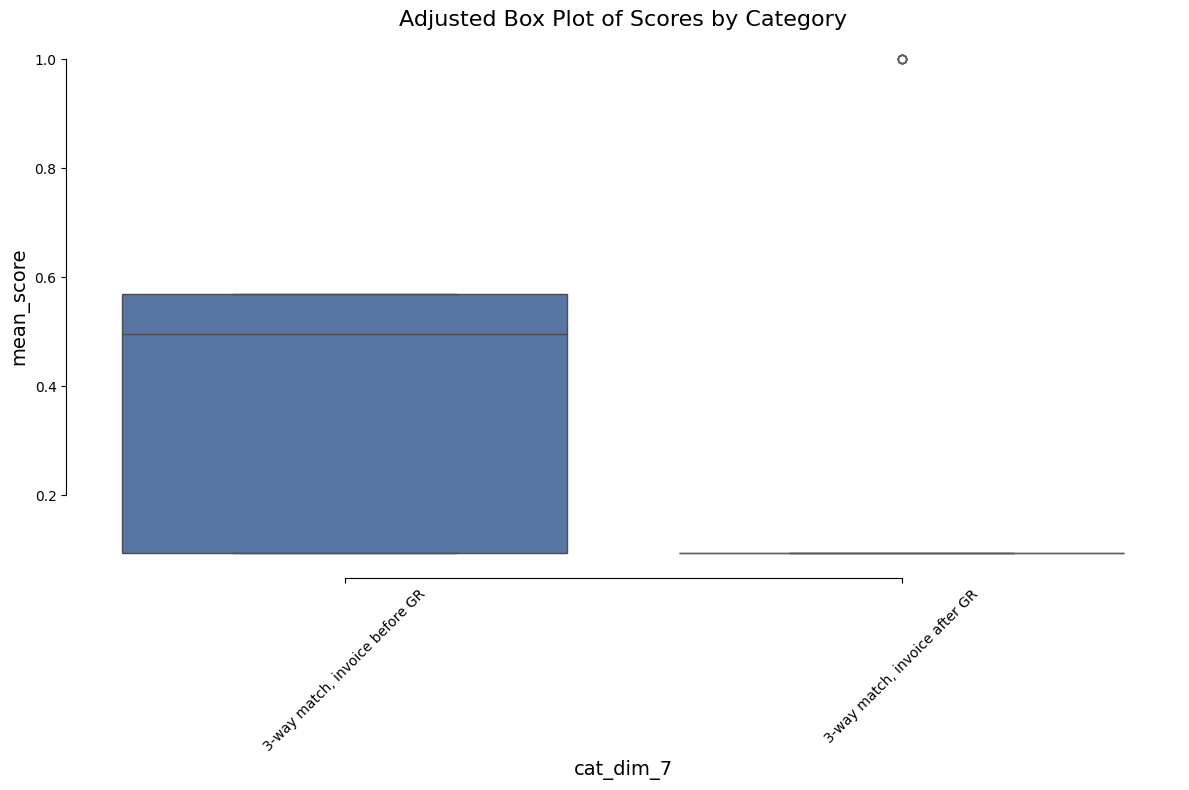

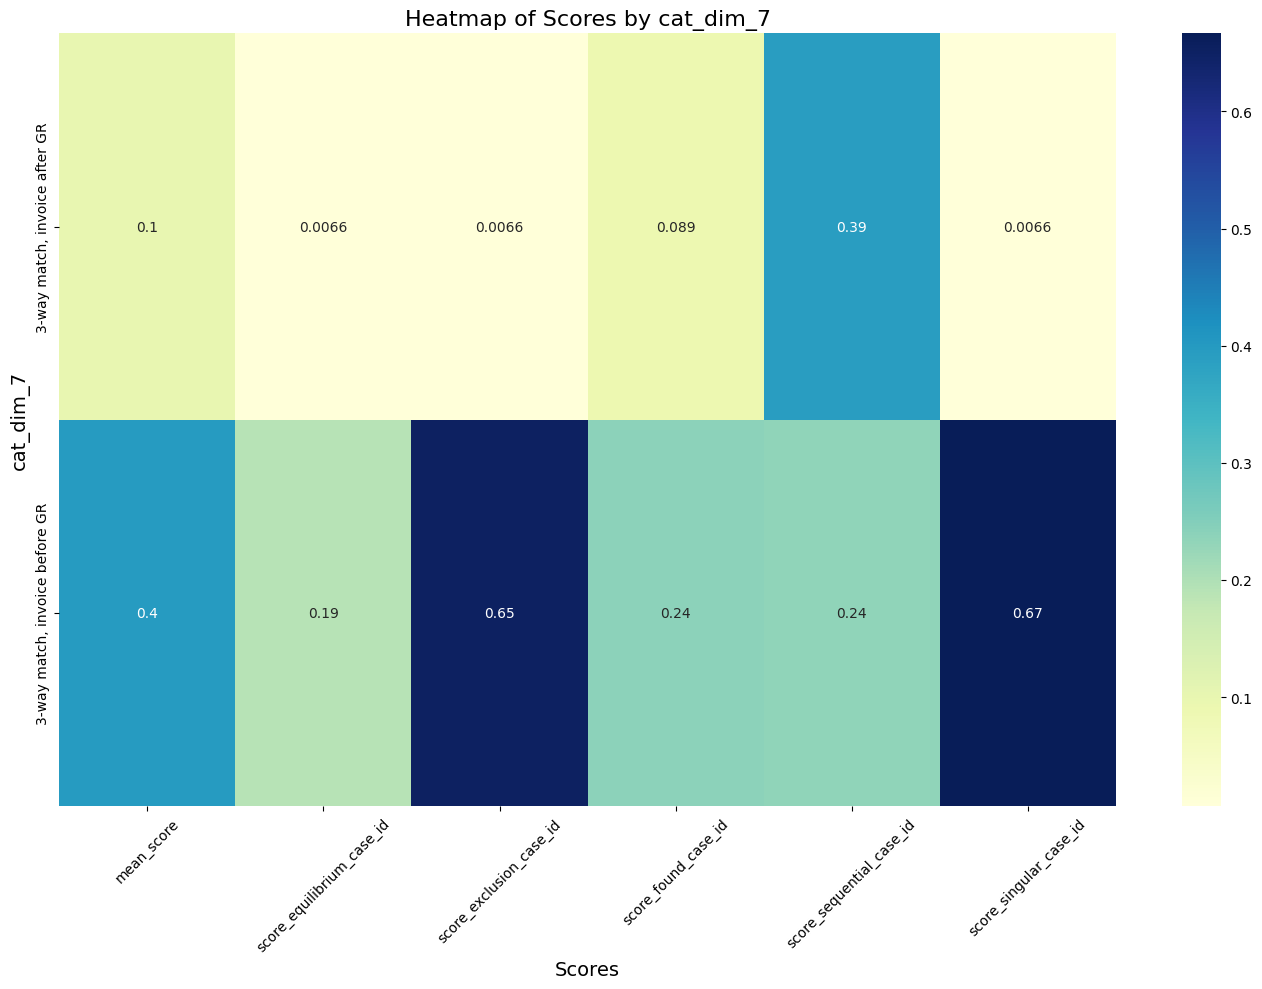

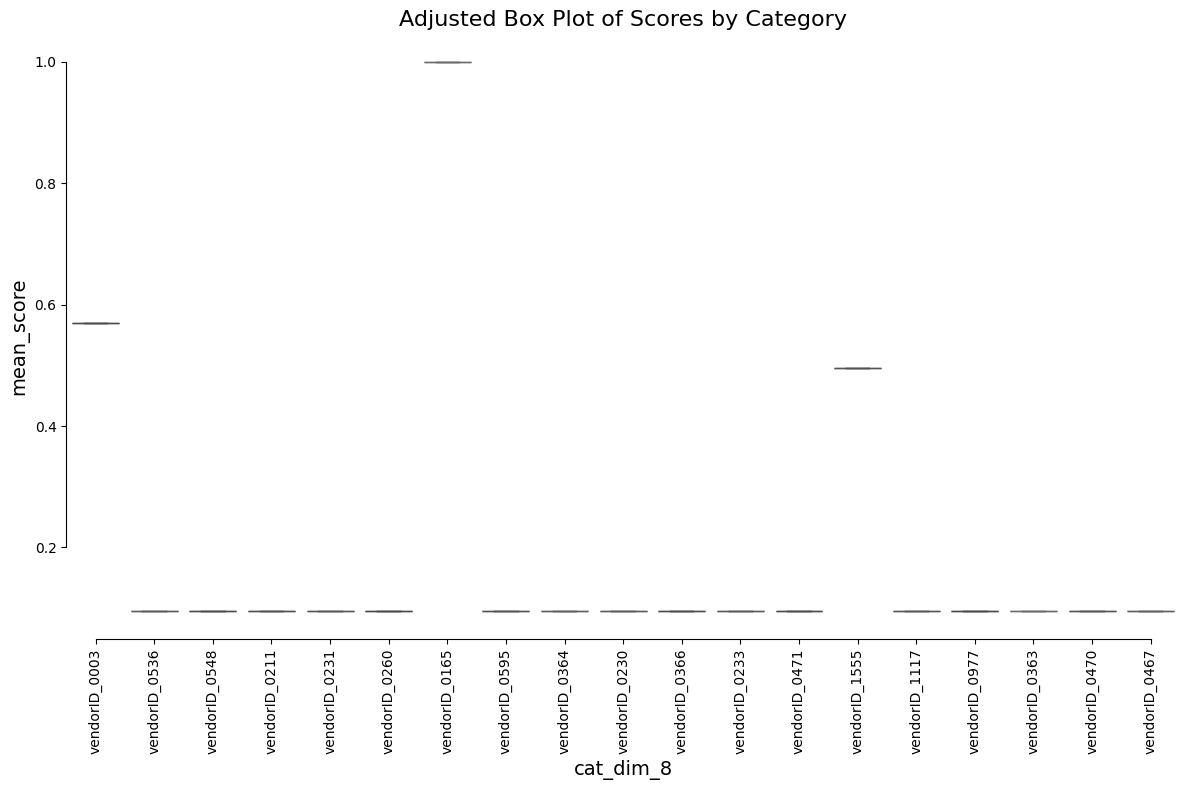

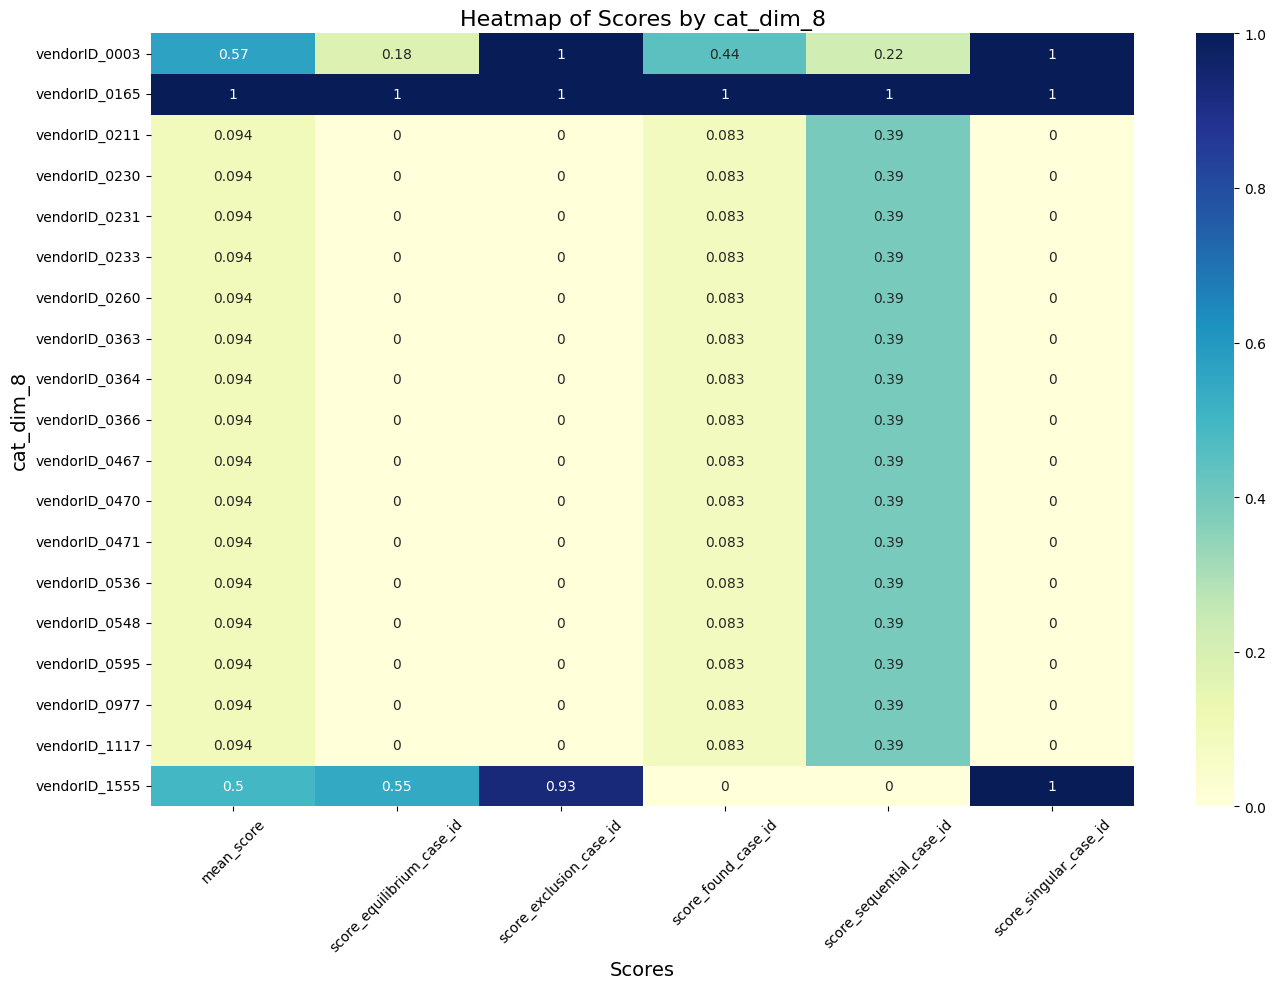

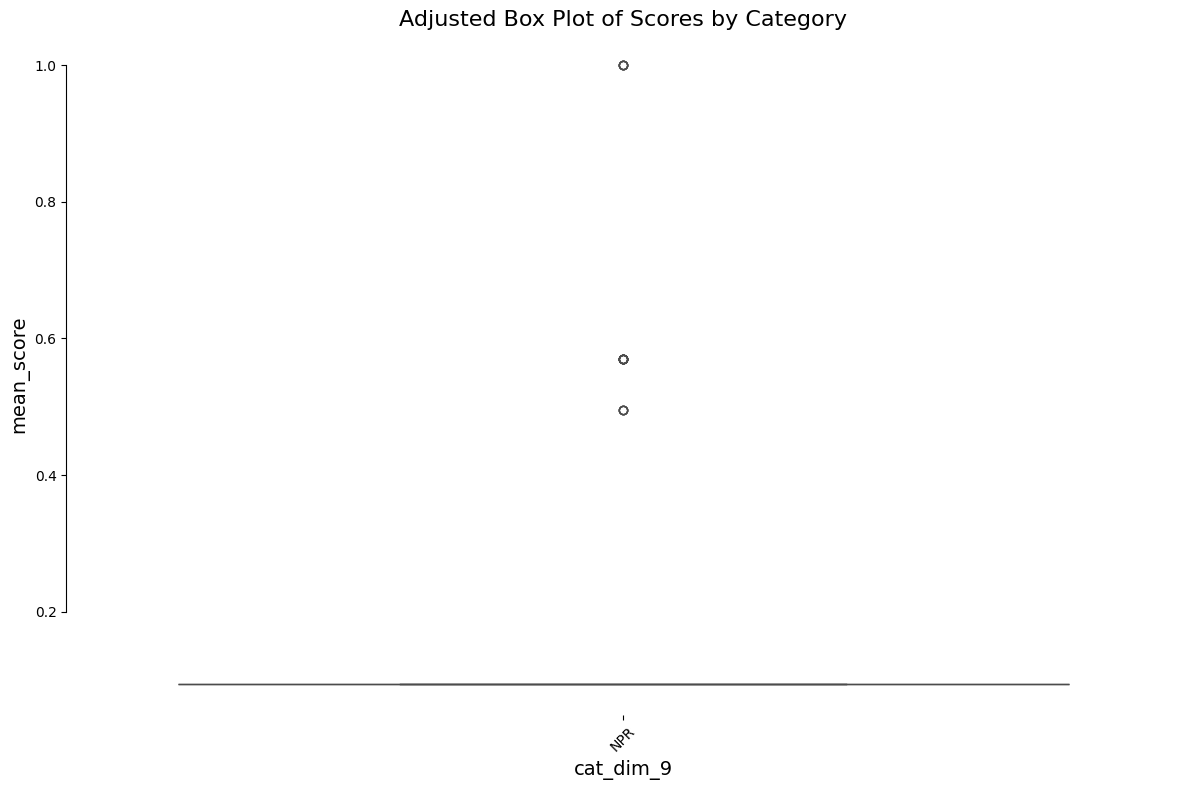

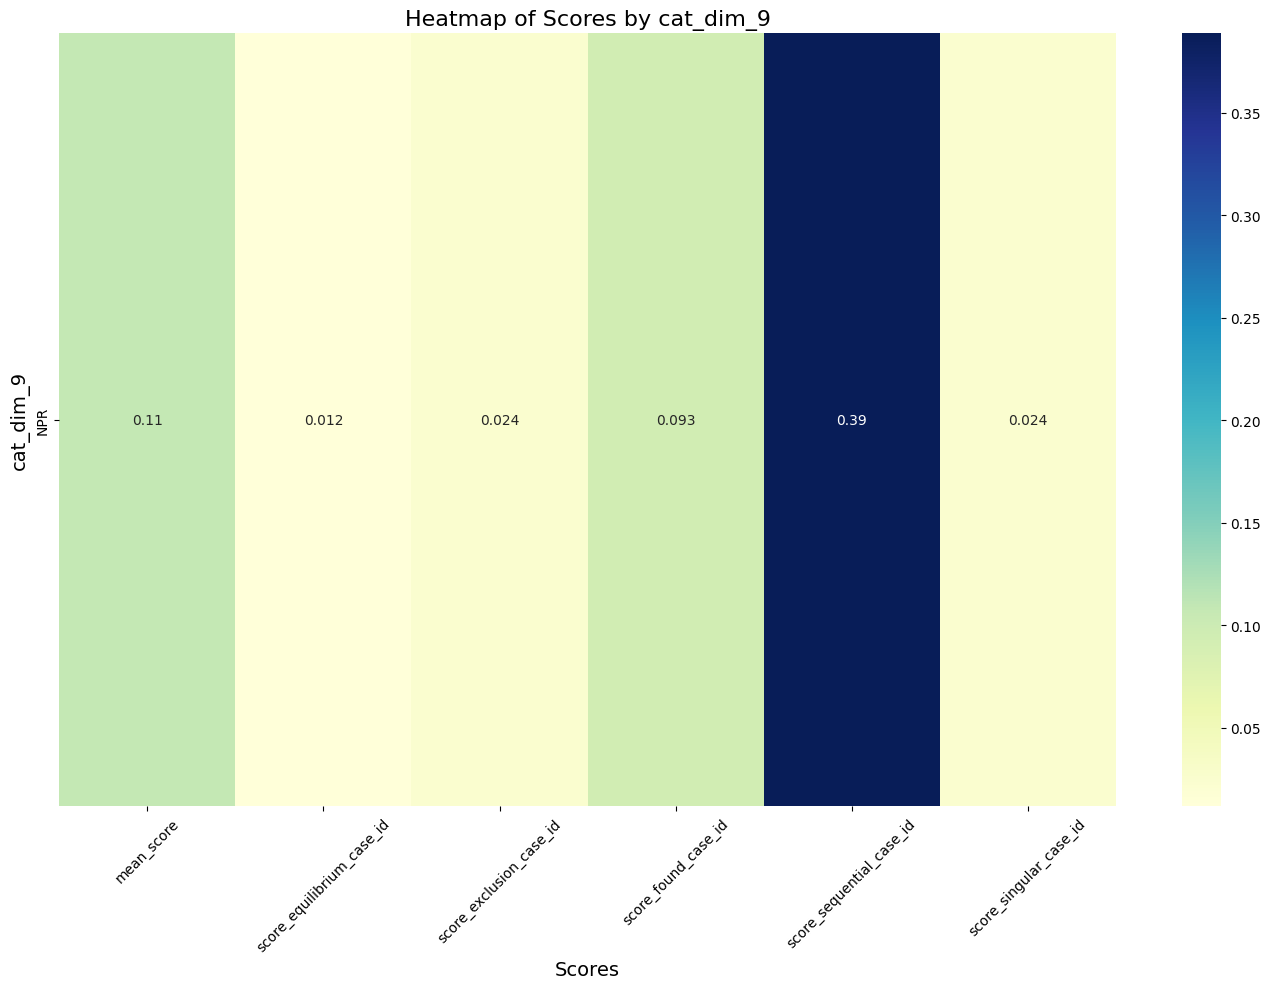

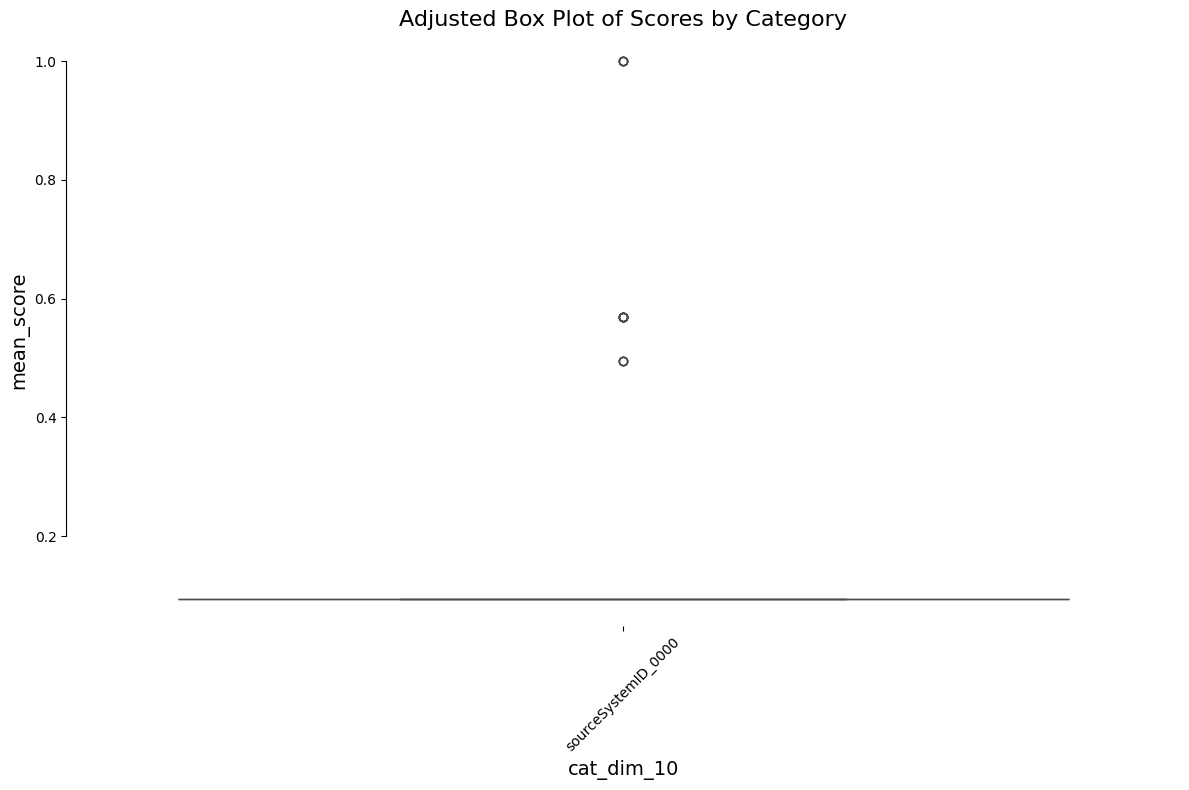

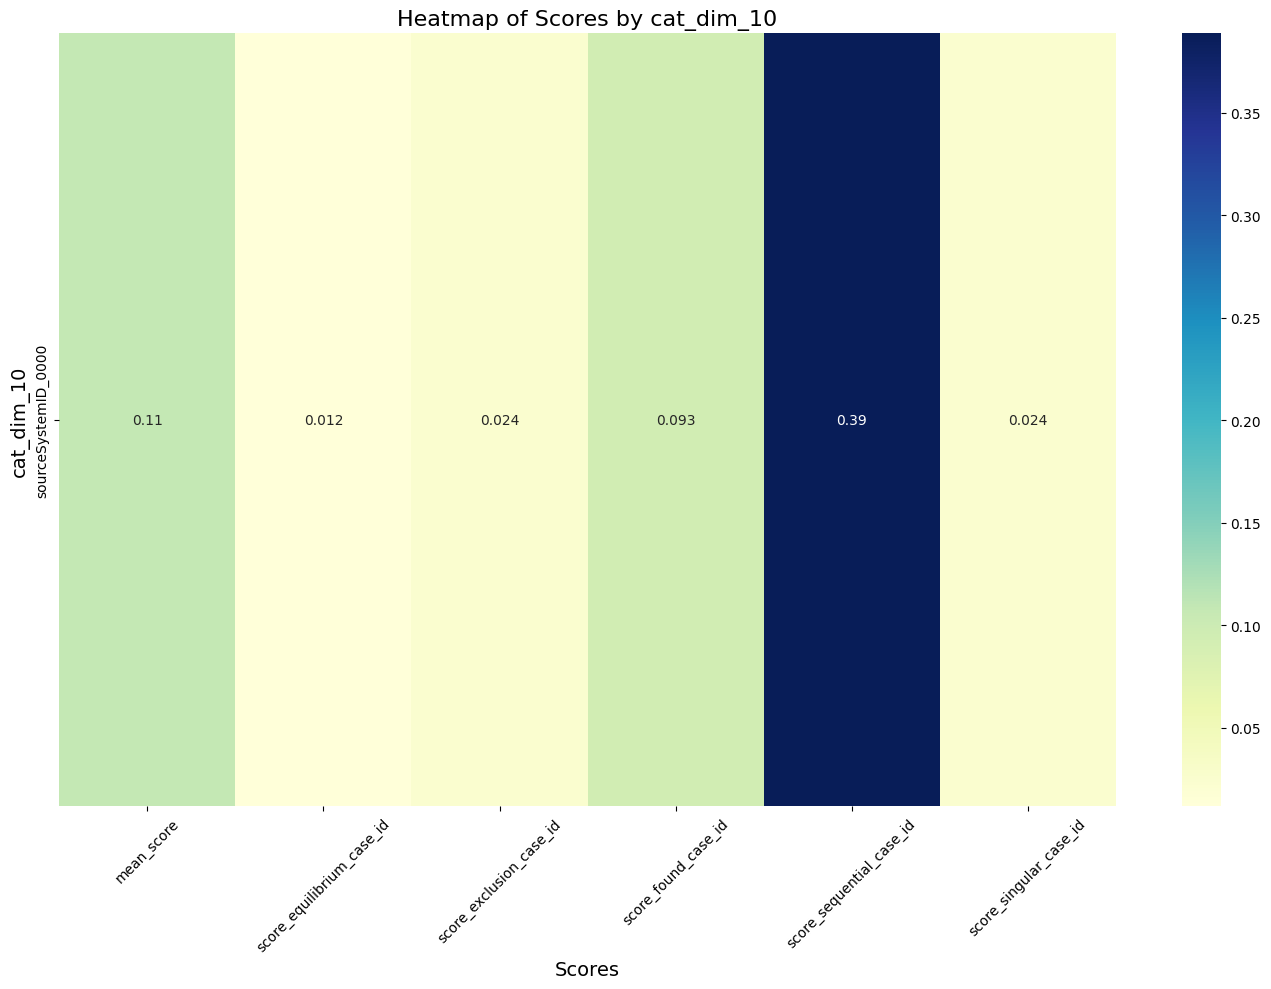

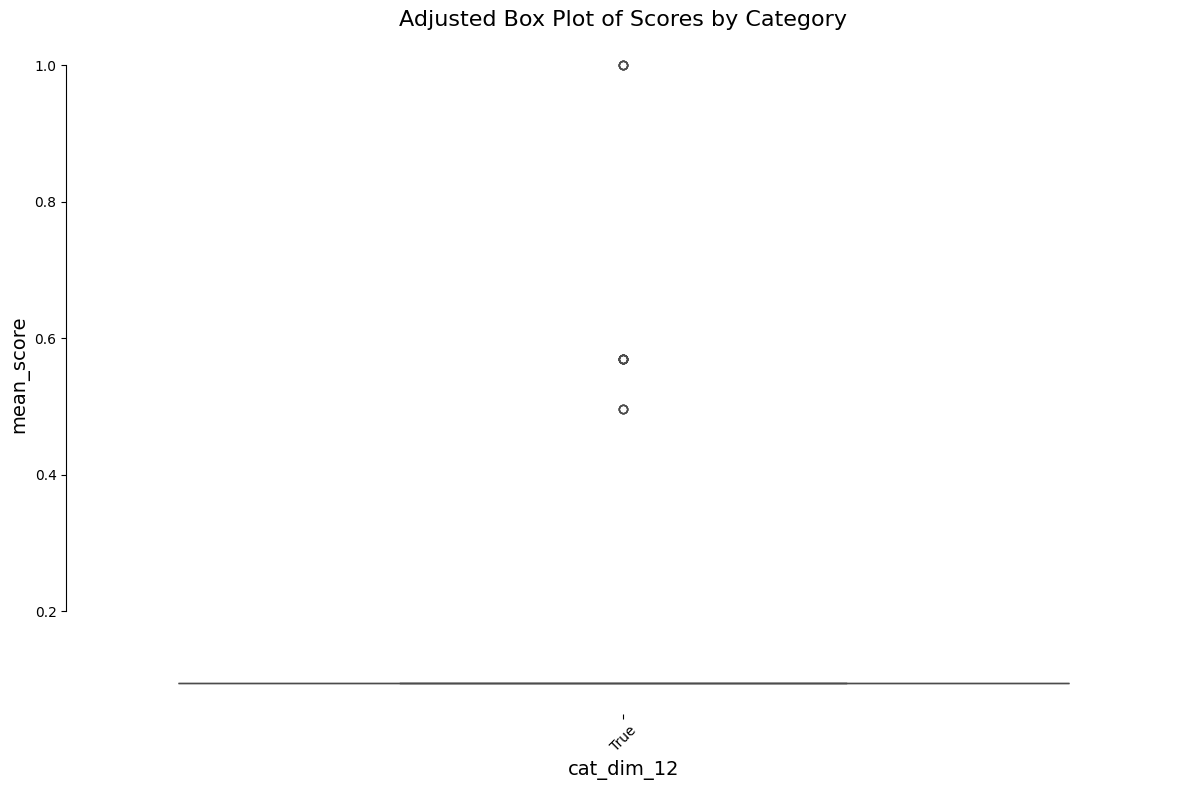

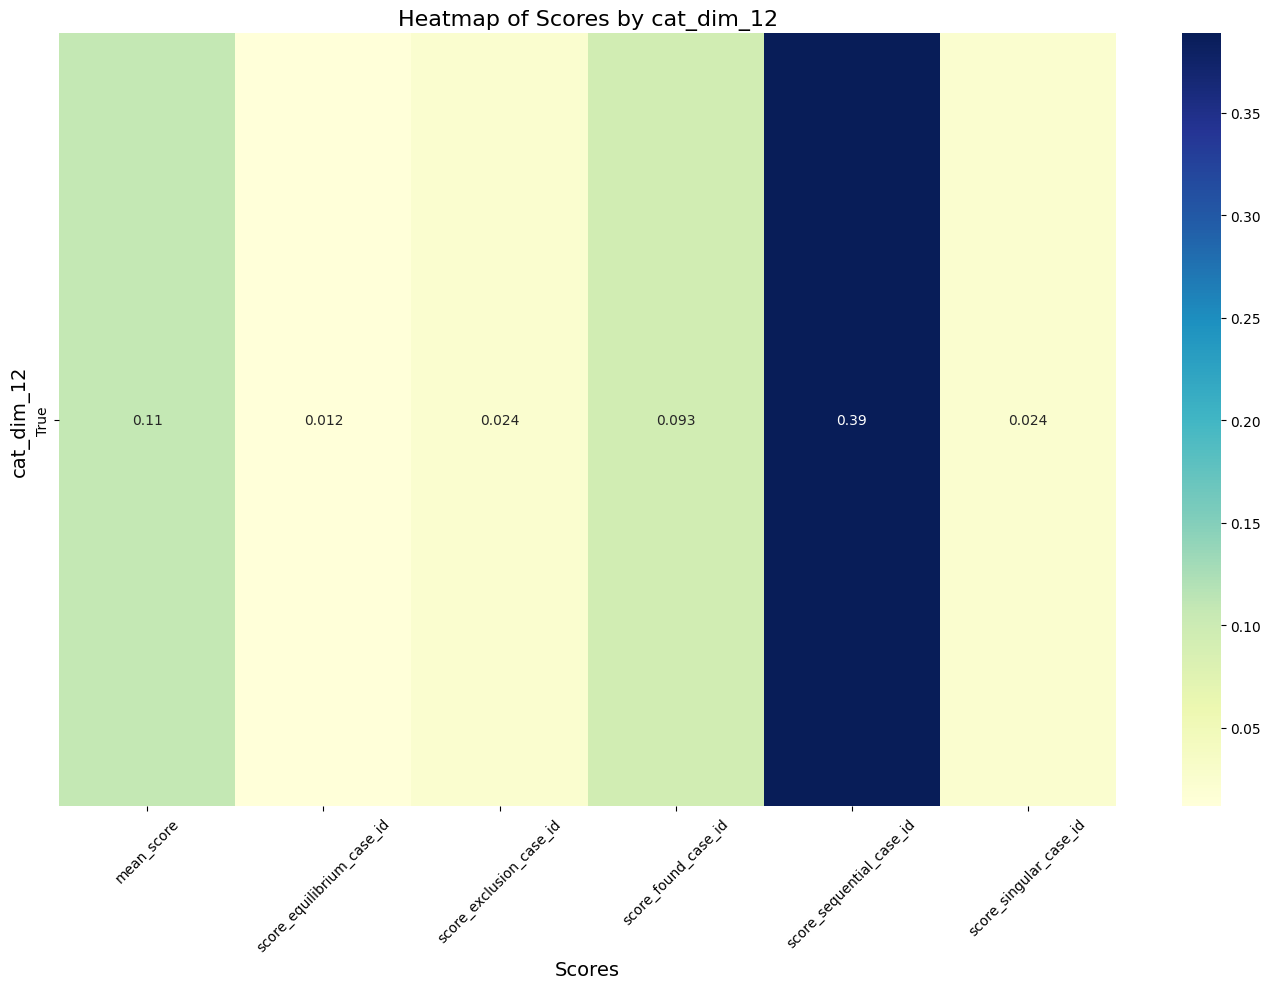

In [4]:
data_selected = data[data['cat_dim_5'].isin(['Enterprise Services', 'Logistics'])]
categories = ['cat_dim_2', 'cat_dim_3',  'cat_dim_5', 'cat_dim_6', 'cat_dim_7', 'cat_dim_8', 'cat_dim_9', 'cat_dim_10', 'cat_dim_12']
for cat in categories:
    analyze_performance(visualize=True, category=cat, score='mean_score', data_filtered=data_selected, path='/Users/urszulajessen/code/gitHub/WISE/data/results/data_BPIC_2019/data_BPIC_2019_Logistics/')

In [5]:


def describe_data(data, all_data):
    """
    Describes the data with basic statistics.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.
    """
    print(data.describe())
    print("\n")
    print("Number of unique values in each column:")
    print(data.nunique())
    print("\n")
    print("Number of missing values in each column:")
    print(data.isnull().sum())
    print("\n")
    print("Correlation between numeric columns:")
    num_cols = data.select_dtypes(include='number').columns
    print(data[num_cols].corr())
    print("\n")
    #Percentage of data against all data
    print("Percentage of data against all data:")
    print(data.shape[0]/all_data.shape[0])

def select_high_variability_categories(data):
    """
    Selects categories with high variability for further analysis.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing the data with a column named 'cat_dim_5' for categories.

    Returns:
    - pd.DataFrame: Filtered DataFrame containing only the selected high variability categories.
    """
    # Define the categories with high variability
    high_variability_categories = ['Additives', 'Logistics', 'Specialty Resins']

    # Filter the data for these categories
    filtered_data = data[data['cat_dim_5'].isin(high_variability_categories)]
    
    return filtered_data

def plot_category_scores(data, category_column, score_column='mean_score'):
    """
    Plots boxplot for the selected category and score column with unique colors for each category using a calmer color palette.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.
    - category_column (str): The category column to plot.
    - score_column (str): The score column to use for plotting.
    """
    plt.figure(figsize=(12, 8))
    # Creating a color palette that can dynamically adjust to the number of categories
    unique_categories = data[category_column].nunique()
    # Using 'muted' palette for calmer colors
    palette = sns.color_palette("muted", unique_categories)
    
    # Plotting with the color palette
    sns.boxplot(x=category_column, y=score_column, data=data, palette=palette)
    plt.title(f'Box Plot of {score_column} by {category_column}')
    plt.xticks(rotation=90)
    plt.xlabel(category_column)
    plt.ylabel(score_column)
    sns.despine(trim=True)
    plt.show()

def interactive_plot(data, all_data):
    """
    Creates an interactive plot with a dropdown to select the category column.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing the data.
    """
    describe_data(data, all_data)

    category_columns = [col for col in data.columns if col.startswith('cat_dim')]
    
    dropdown = widgets.Dropdown(
        options=category_columns,
        value=category_columns[0],
        description='Category:',
        disabled=False,
    )
    
    def update_plot(category_column):
        plot_category_scores(data, category_column=category_column)

    interactive_widget = widgets.interactive(update_plot, category_column=dropdown)
    display(interactive_widget)


#data_high_variability = select_high_variability_categories(data)  # Assuming 'data' is defined and contains relevant columns
interactive_plot(data_selected,data)


            eventID  case_Purchasing_Document   case_Item      num_dim_1  \
count  7.800000e+02              7.800000e+02  780.000000     780.000000   
mean   6.396290e+14              4.475444e+09    2.876923    2180.521795   
std    3.177905e+14              2.822784e+08    6.030324   16058.415367   
min    1.524284e+13              2.000053e+09    1.000000       0.000000   
25%    4.471276e+14              4.507031e+09    1.000000      39.000000   
50%    6.661408e+14              4.508046e+09    1.000000      80.500000   
75%    8.821605e+14              4.508062e+09    1.000000     667.000000   
max    1.049746e+15              4.508074e+09   40.000000  331513.000000   

           @@index  @@case_index  score_found_case_id  \
count   780.000000    780.000000           780.000000   
mean   4042.776923    584.643590             0.000015   
std    1836.120265    300.107509             0.000126   
min     511.000000      5.000000            -0.000125   
25%    2948.750000    416.0000

interactive(children=(Dropdown(description='Category:', options=('cat_dim_5', 'cat_dim_4', 'cat_dim_3', 'cat_d…

In [6]:
summary = analyze_agents(summary_needed=True, categories=categories, folder_path='/Users/urszulajessen/code/gitHub/WISE/data/results/data_BPIC_2019/data_BPIC_2019_Logistics/')

In [7]:
summary

'## Detailed and Actionable Plan for Process Improvement\n\n### Main Points and Quantifiable Targets:\n\n1. **Enhance Equilibrium (Balanced Distribution)**\n   - Current Score: 0.012\n   - Target Score: >0.5 within 6 months\n\n2. **Reduce Unwanted Activities (Absence of Unwanted Activities)**\n   - Current Score: 0.024\n   - Target Score: >0.5 within 6 months\n\n3. **Minimize Duplicate Activities (Absence of Duplicate Activities)**\n   - Current Score: 0.024\n   - Target Score: >0.5 within 6 months\n\n4. **Maintain and Improve Sequential Execution (Correct Order)**\n   - Current Score: 0.39\n   - Target Score: >0.6 within 3 months\n\n5. **Enhance Presence of Mandatory Activities (Presence of Mandatory Activities)**\n   - Current Score: 0.093\n   - Target Score: >0.5 within 4 months\n\n### Steps to be Taken:\n\n#### 1. Enhance Equilibrium:\n   - **Analyze Activity Distribution**:\n     - Tools: Workload distribution analysis tools.\n     - Action: Redistribute tasks evenly.\n     - Resp

## Get detailed analysis for each category


# Logistic Analysis

From provided analysis especially sequential scoring seems to be the feature with the most impact on the target variable.
## Detailed Analysis of Sequential Scoring for Marketing Category in BPIC_2019 Dataset
'## Detailed and Actionable Plan for Process Improvement
\n\n
### Main Points and Quantifiable Targets:\n\n1. 
**Enhance Equilibrium (Balanced Distribution)**
\n   - Current Score: 0.012\n   - Target Score: >0.5 within 6 months\n\n2. 
**Reduce Unwanted Activities (Absence of Unwanted Activities)**
\n   - Current Score: 0.024\n   - Target Score: >0.5 within 6 months\n\n3. 
**Minimize Duplicate Activities (Absence of Duplicate Activities)**
\n   - Current Score: 0.024\n   - Target Score: >0.5 within 6 months\n\n4. 
**Maintain and Improve Sequential Execution (Correct Order)**
\n   - Current Score: 0.39\n   - Target Score: >0.6 within 3 months\n\n5. 
**Enhance Presence of Mandatory Activities (Presence of Mandatory Activities)**
\n   - Current Score: 0.093\n   - Target Score: >0.5 within 4 months\n\n
### Steps to be Taken:\n\n
#### 1. Enhance Equilibrium:\n   
- **Analyze Activity Distribution**:\n     
- Tools: Workload distribution analysis tools.\n    
 - Action: Redistribute tasks evenly.\n     
 - Responsible: Process Managers.\n     
 - Deadline: Within 2 months.\n  \n   - 
 **Resource Allocation Optimization**:\n     
 - Tools: Time tracking and balancing software.\n    
  - Action: Optimize resource allocation.\n     
  - Responsible: Project Leads.\n     
  - Deadline: Within 3 months.\n\n
  #### 2. Reduce Unwanted Activities:\n   - 
  **Process Automation**:\n     
  - Tools: Automation software.\n     
  - Action: Automate manual processes.\n     
  - Responsible: IT and Automation Teams.\n     
  - Deadline: Within 4 months.\n  \n   
  - **Lean Process Reviews**:\n     
  - Tools: Lean management principles.\n     
  - Action: Identify and eliminate unwanted activities.\n     
  - Responsible: Process Improvement Teams.\n     
  - Deadline: Bi-monthly reviews.\n\n
  #### 3. Minimize Duplicate Activities:\n   - 
  **Duplicate Detection Mechanisms**:\n     - Tools: Duplicate detection software.\n     - Action: Implement and monitor duplicate detection.\n     - Responsible: IT Department.\n     - Deadline: Within 2 months.\n  \n   - **Validation and Checks Implementation**:\n     - Tools: Validation software.\n     - Action: Set up checks for preventing duplicate activities.\n     - Responsible: Quality Assurance Teams.\n     - Deadline: Within 3 months.\n\n#### 4. Maintain and Improve Sequential Execution:\n   - **Sequential Validation**:\n     - Tools: Workflow validation tools.\n     - Action: Regularly validate sequencing of activities.\n     - Responsible: Operations Teams.\n     - Deadline: Monthly checks.\n  \n   - **Training Programs**:\n     - Tools: Training workshops.\n     - Action: Train employees on correct order of processes.\n     - Responsible: Training and Development Teams.\n     - Deadline: Quarterly sessions.\n\n#### 5. Enhance Presence of Mandatory Activities:\n   - **Regular Audits**:\n     - Tools: Audit and compliance software.\n     - Action: Perform regular audits to ensure all mandatory activities are present.\n     - Responsible: Compliance Teams.\n     - Deadline: Monthly audits.\n  \n   - **Check and Validation Systems**:\n     - Tools: Real-time checking systems.\n     - Action: Implement real-time checks for mandatory activities.\n     - Responsible: Process Monitoring Teams.\n     - Deadline: Within 3 months.\n\n### Monitoring and Evaluation:\n\n- **Real-Time Monitoring**:\n   - Tools: Process monitoring dashboards.\n   - Action: Setup real-time monitoring for ongoing tracking.\n   - Responsible: IT and Process Monitoring Teams.\n   - Deadline: Initial setup within 2 months, ongoing monitoring.\n\n- **Weekly Tracking**:\n   - Tools: Weekly progress reports.\n   - Action: Monitor the progress weekly with detailed reports.\n   - Responsible: Process Managers.\n   - Deadline: Start weekly reports within 1 month.\n\n- **Monthly Evaluation Reports**:\n   - Tools: Performance analytics software.\n   - Action: Generate and review monthly performance evaluation reports.\n   - Responsible: Data Analysis Teams.\n   - Deadline: Regularly, starting immediately.\n\n### Summary of Quantifiable Targets:\n  - **Enhance Equilibrium**: From 0.012 to >0.5 in 6 months.\n  - **Reduce Unwanted Activities**: From 0.024 to >0.5 in 6 months.\n  - **Minimize Duplicate Activities**: From 0.024 to >0.5 in 6 months.\n  - **Improve Sequential Execution**: From 0.39 to >0.6 in 3 months.\n  - **Enhance Presence of Mandatory Activities**: From 0.093 to >0.5 in 4 months.'